In [ ]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from pytorch_metric_learning import distances
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torchvision
from tqdm.notebook import tqdm

In [ ]:
# !pip install kornia
# !pip install kornia_moons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone 'https://github.com/magicleap/SuperGluePretrainedNetwork'

Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 182, done.
remote: Total 182 (delta 0), reused 0 (delta 0), pack-reused 182
Receiving objects: 100% (182/182), 118.85 MiB | 30.54 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (89/89), done.


In [ ]:
%cd SuperGluePretrainedNetwork/

/content/SuperGluePretrainedNetwork


In [ ]:
!ls

assets		   LICENSE	   models     requirements.txt
demo_superglue.py  match_pairs.py  README.md


In [ ]:
my_path = '/content/drive/MyDrive/Cow Data/Images/Subset/'
print(os.listdir(my_path))

def prepare(class1, class2):
    with open('pairs.txt', 'w') as f:
        files1 = os.listdir(my_path+f'{class1}')
        files2 = os.listdir(my_path+f'{class2}')[::-1]

        for i in range(min(len(files1), len(files2))-1):
            f.write(f'{class1}/{files1[i]} {class2}/{files2[i]} \n')

['959', '961', '951', '972', '960', '966', '963', '956', '949', '948', '971', '953', '967', '965', '947', '976', '974', '970', '952', '958', '968', '962', '955', '950', '973']


In [ ]:
prepare(965,972)
!python3 'match_pairs.py' --input_dir '../drive/MyDrive/Cow Data/Images/Subset/' --input_pairs 'pairs.txt' --viz

Namespace(input_pairs='pairs.txt', input_dir='../drive/MyDrive/Cow Data/Images/Subset/', output_dir='dump_match_pairs/', max_length=-1, resize=[640, 480], resize_float=False, superglue='indoor', max_keypoints=1024, keypoint_threshold=0.005, nms_radius=4, sinkhorn_iterations=20, match_threshold=0.2, viz=True, eval=False, fast_viz=False, cache=False, show_keypoints=False, viz_extension='png', opencv_display=False, shuffle=False, force_cpu=False)
Will resize to 640x480 (WxH)
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Looking for data in directory "../drive/MyDrive/Cow Data/Images/Subset"
Will write matches to directory "dump_match_pairs"
Will write visualization images to directory "dump_match_pairs"
[Finished pair     0 of     4] load_image=0.051 matcher=4.276 viz_match=0.619 total=4.945 sec {0.2 FPS} 
[Finished pair     1 of     4] load_image=0.135 matcher=4.744 viz_match=0.617 total=5.495 sec {0.2 FPS} 
[Finished pair     2 of   

In [ ]:
!rm -r dump_match_pairs

# LOFTR

In [ ]:
from kornia.feature import LoFTR
import kornia as K
import kornia.feature as KF
import cv2
from kornia_moons.feature import *
from PIL import Image
from kornia_moons.feature import draw_LAF_matches

In [ ]:
config = dict(
    saved_path="/content/drive/MyDrive/Cow Data/Saved_models/rough.pt",
    lr=0.001,
    EPOCHS = 5,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device='cpu',
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

random.seed(config['SEED'])
np.random.seed(config['SEED'])
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAutocontrast(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
my_path = '/content/drive/MyDrive/Cow Data/Images/Subset/'
print(os.listdir(my_path+'950'))

['IMG_20200930_162510.jpg', 'IMG_20200930_162507.jpg', 'IMG_20200930_162513.jpg', 'IMG_20200930_162509.jpg', 'IMG_20200930_162515.jpg', 'IMG_20200930_162522.jpg', 'IMG_20200930_162514.jpg']


In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

image1 = pil_loader(my_path+'950/IMG_20200930_162510.jpg')
image2 = pil_loader(my_path+'950/IMG_20200930_162522.jpg')

x1 = data_transforms['test'](image1)
x1 = torch.Tensor(np.expand_dims(x1,axis = 0))

x2 = data_transforms['test'](image2)
x2 = torch.Tensor(np.expand_dims(x2,axis = 0))

x1 = K.color.rgb_to_grayscale(x1)
x2 = K.color.rgb_to_grayscale(x2)

x1.shape, x2.shape, x1.size(0)

(torch.Size([1, 1, 224, 224]), torch.Size([1, 1, 224, 224]), 1)

In [ ]:
matcher = LoFTR(pretrained="outdoor")
input = {"image0": x1, "image1": x2}
correspondences = matcher(input)

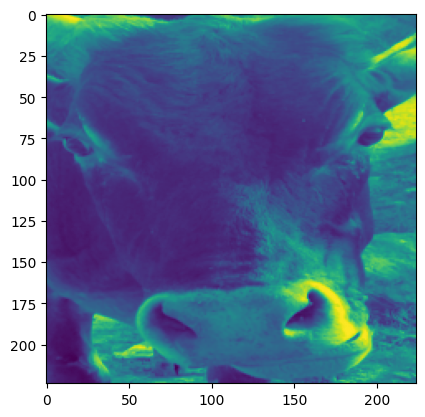

In [ ]:
plt.imshow(x2[0,0,:,:])

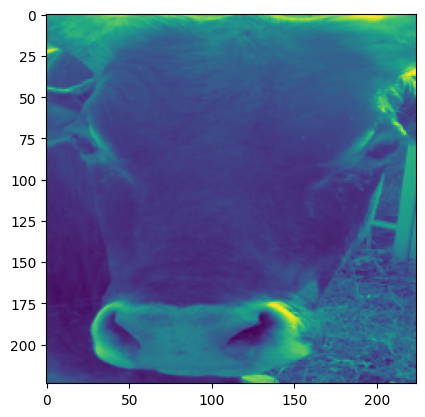

In [ ]:
plt.imshow(x1[0,0,:,:])

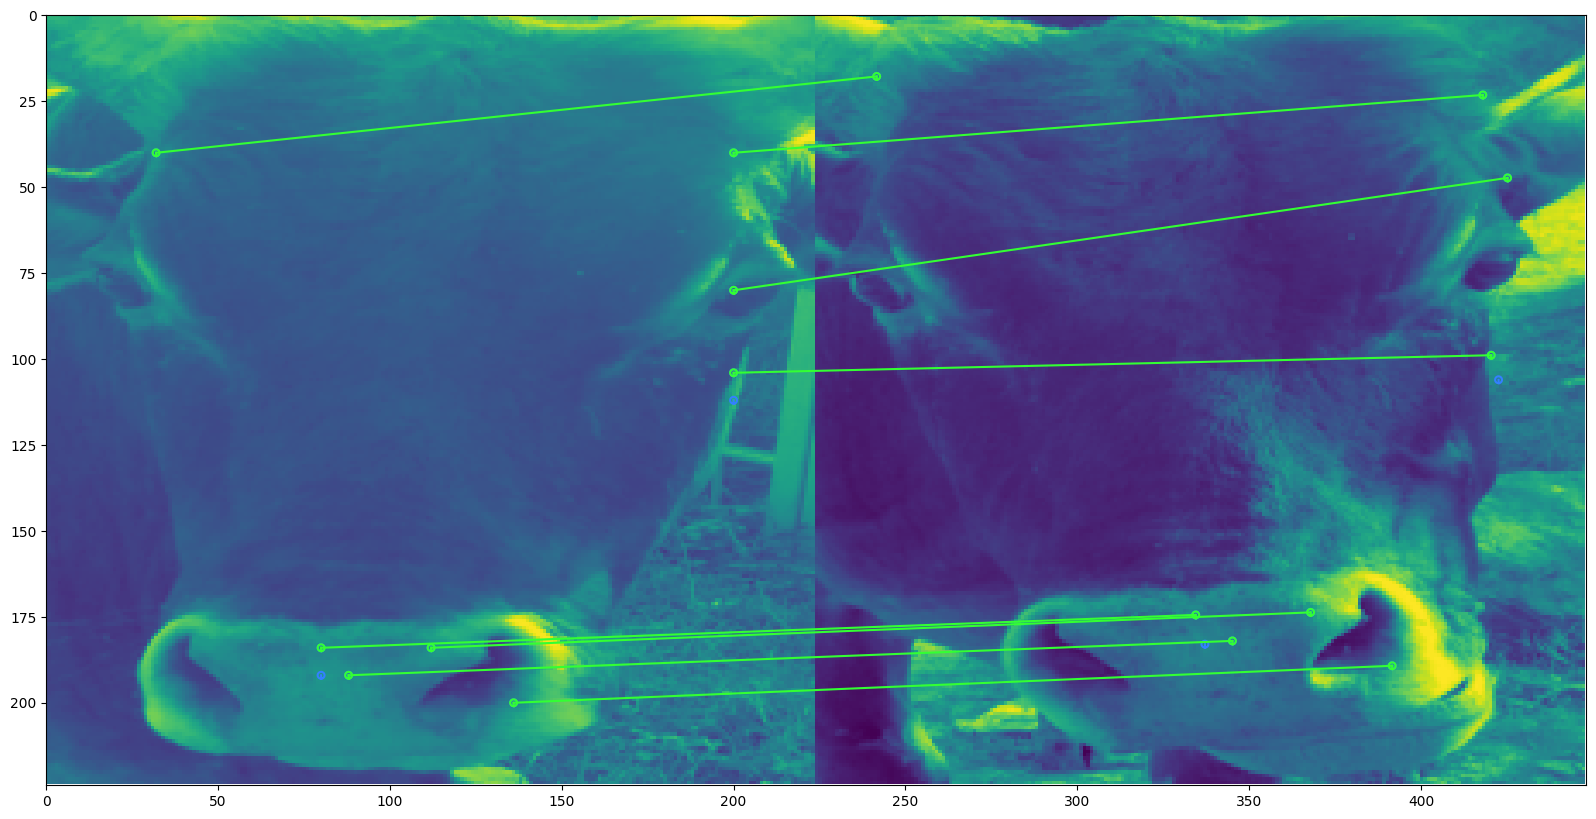

In [ ]:
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

draw_LAF_matches(
KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                            torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                            torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                            torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                            torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
K.tensor_to_image(x1),
K.tensor_to_image(x2),
inliers,
draw_dict={'inlier_color': (0.2, 1, 0.2),
            'tentative_color': None,
            'feature_color': (0.2, 0.5, 1), 'vertical': False})